In [129]:
import os
import sys
import glob
import re
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from IPython.display import display
from pathlib import Path
from smart_open import open
from tqdm.autonotebook import tqdm
tqdm.pandas()

import gensim
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score, ShuffleSplit, train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

import seaborn as sns

import spacy
from spacy.pipeline import EntityRuler

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = stopwords.words('english')

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\infomax\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [444]:
nlp = spacy.load('en_core_web_lg')

In [3]:
data = []
for cat in tqdm(os.listdir('bbc')):
    for fname in glob.glob('bbc/' + cat + '/*.txt'):
        file = Path(fname)
        iid = cat + '-' + file.name.split('.')[0]
        try:
            txt = file.read_text(encoding='latin-1')
        except:
            print(iid)
        data.append([iid, txt, cat])
        
df = pd.DataFrame(data, columns=['ArticleId', 'Text', 'Category']); df

,ArticleId,Text,Category
0,business-001,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,business-002,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,business-003,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,business-004,High fuel prices hit BA's profits\n\nBritish A...,business
4,business-005,Pernod takeover talk lifts Domecq\n\nShares in...,business
5,business-006,Japan narrowly escapes recession\n\nJapan's ec...,business
6,business-007,Jobs growth still slow in the US\n\nThe US cre...,business
7,business-008,"India calls for fair trade rules\n\nIndia, whi...",business
8,business-009,Ethiopia's crop production up 24%\n\nEthiopia ...,business
9,business-010,Court rejects $280bn tobacco case\n\nA US gove...,business


In [119]:
df.Text[100]

'Australia rates at four year high\n\nAustralia is raising its benchmark interest rate to its highest level in four years despite signs of a slowdown in the country\'s economy.\n\nThe Reserve Bank of Australia lifted interest rates 0.25% to 5.5%, their first upwards move in more than a year. However, shortly after the Bank made its decision, new figures showed a fall in economic growth in the last quarter. The Bank said it had acted to curb inflation but the move was criticised by some analysts.\n\nThe rate hike was the first since December 2003 and had been well-flagged in advance. However, opposition parties and some analysts said the move was ill-timed given data showing the Australian economy grew just 0.1% between October and December and 1.5% on an annual basis.\n\nThe figures, representing a decline from the 0.2% growth in GDP seen between July and September, were below market expectations. Consumer spending remains strong, however, and the Bank is concerned about growing inflat

In [445]:
ruler = EntityRuler(nlp)
patterns = [
    {"label": "MONEY", "pattern": [{"TEXT": "$"}, {"POS": "NUM"}]},
    {"label": "MONEY", "pattern": [{"TEXT": "€"}, {"POS": "NUM"}]},
    {"label": "MONEY", "pattern": [{"TEXT": "¥"}, {"POS": "NUM"}]},
    {"label": "MONEY", "pattern": [{"TEXT": "£"}, {"POS": "NUM"}]},
#     {"label": "MONEY", "pattern": [{"TEXT": {"REGEX": r"[\$|€|¥|£]"}}, {"POS": "NUM"}]} #원화\ 는 잘 안된다...
]
ruler.add_patterns(patterns)

if nlp.has_pipe('entity_ruler'):
    nlp.replace_pipe('entity_ruler', ruler)
    
else:
    nlp.add_pipe(ruler, before='ner')
    
nlp.get_pipe('entity_ruler').patterns

[{'label': 'MONEY', 'pattern': [{'TEXT': '$'}, {'POS': 'NUM'}]},
 {'label': 'MONEY', 'pattern': [{'TEXT': '€'}, {'POS': 'NUM'}]},
 {'label': 'MONEY', 'pattern': [{'TEXT': '¥'}, {'POS': 'NUM'}]},
 {'label': 'MONEY', 'pattern': [{'TEXT': '£'}, {'POS': 'NUM'}]}]

In [446]:
def filter_spans(spans):
    get_sort_key = lambda span: (span.end - span.start, span.start)
    sorted_spans = sorted(spans, key=get_sort_key, reverse=True)
    result = []
    seen_tokens = set()
    
    for span in sorted_spans:
        if span.start not in seen_tokens and span.end -1 not in seen_tokens:
            result.append(span)
            seen_tokens.update(range(span.start, span.end))
    
    return result


def tokenize(rawdoc):
    doc = nlp(re.sub(r'\n+', r'\n', rawdoc))
    spans = list(doc.ents)

#     for nc in doc.noun_chunks:
#         #if nc.text == 'the 0.2% growth': set_trace()
#         while len(nc)>1 and nc[0].dep_ not in ('advmod', 'amod', 'compound', 'nummod'):
#             nc = nc[1:]
            
#         spans.append(nc)
        
    spans = filter_spans(spans)
    with doc.retokenize() as retokenizer:
        for span in spans:
            root = span.root
            # entity인 2%의 lemma가 2 %가 되기 때문에, 이경우 2-%가 된다. 
            # 이런 경우를 제외하기 위해, 그냥 span.text를 썼다 (2019.09.17)
            lemma = span.text.replace(' ', '_') if len(span)>1 else span.lemma_
            attrs = {'tag':root.tag_, 'lemma':lemma, 'ent_type':root.ent_type_}
            retokenizer.merge(span, attrs=attrs)
            
    return doc


def lemmatize(doc, allowed_pos=['NOUN', 'ADJ', 'VERB', 'ADV', 'NUM', 'PROPN']):
#     for tok in doc:
#         if tok.is_stop or tok.is_punct or tok.pos_ not in allowed_pos:
#             continue
        
#         print(tok.text, tok.lemma_, tok.pos_, tok.ent_type_, tok.is_stop)
        
    return [tok.lemma_.lower() for tok in doc if not(tok.is_stop or tok.is_punct or tok.is_space or tok.pos_ not in allowed_pos)]

In [122]:
for e in nlp(df.Text[100]).noun_chunks:
    print(e.text, e.lemma_, e.label_, len(e))

Australia rates Australia rate NP 2
four year high

Australia four year high 

 Australia NP 5
its benchmark interest rate -PRON- benchmark interest rate NP 4
its highest level -PRON- high level NP 3
four years four year NP 2
signs sign NP 1
a slowdown a slowdown NP 2
the country's economy the country 's economy NP 4
The Reserve Bank the Reserve Bank NP 3
Australia Australia NP 1
interest rates interest rate NP 2
5.5% 5.5 % NP 2
more than a year more than a year NP 4
the Bank the Bank NP 2
its decision -PRON- decision NP 2
new figures new figure NP 2
a fall a fall NP 2
economic growth economic growth NP 2
the last quarter the last quarter NP 3
The Bank the Bank NP 2
it -PRON- NP 1
inflation inflation NP 1
the move the move NP 2
some analysts some analyst NP 2
The rate hike the rate hike NP 3
December December NP 1
advance advance NP 1
opposition parties opposition party NP 2
some analysts some analyst NP 2
the move the move NP 2
ill-timed given data ill - time give datum NP 5
the Austr

In [124]:
doc_ = re.sub(r'\n+', r'\n', df.Text[100])
doc = nlp(doc_)
for tok in transform_doc(doc):
    print(tok.text, tok.lemma_, tok.pos_, tok.ent_type_, tok.is_stop)

> <ipython-input-123-926077e17ab8>(20)transform_doc()
     18     for nc in doc.noun_chunks:
     19         if nc.text == 'the 0.2% growth': set_trace()
---> 20         while len(nc)>1 and nc[0].dep_ not in ('advmod', 'amod', 'compound'):
     21             nc = nc[1:]
     22 

ipdb> nc
the 0.2% growth
ipdb> nc[0].dep_
'det'
ipdb> n
> <ipython-input-123-926077e17ab8>(21)transform_doc()
     19         if nc.text == 'the 0.2% growth': set_trace()
     20         while len(nc)>1 and nc[0].dep_ not in ('advmod', 'amod', 'compound'):
---> 21             nc = nc[1:]
     22 
     23         spans.append(nc)

ipdb> n
> <ipython-input-123-926077e17ab8>(20)transform_doc()
     18     for nc in doc.noun_chunks:
     19         if nc.text == 'the 0.2% growth': set_trace()
---> 20         while len(nc)>1 and nc[0].dep_ not in ('advmod', 'amod', 'compound'):
     21             nc = nc[1:]
     22 

ipdb> nc
0.2% growth
ipdb> nc[0]
0.2
ipdb> nc[0].dep_
'nummod'
ipdb> n
> <ipython-input-123-9260

BdbQuit: 

In [128]:
doc_ = re.sub(r'\n+', r'\n', df.Text[200])
doc = nlp(doc_)
doc = transform_doc(doc)
lemmatize(doc)

['novartis',
 'hit',
 'acquisition_trail',
 'swiss_drugmaker',
 'novartis',
 'announce',
 '5.65bn_euros',
 '$7.4bn',
 'â£3.9bn',
 'purchase',
 'sandoz_unit',
 'world',
 'big',
 'generic',
 'drug',
 'producer',
 'novartis',
 'last_month',
 'forecast',
 'record',
 'sale',
 '2005',
 'say',
 'buy',
 'germany',
 'hexal',
 'acquire',
 '67.7%',
 'hexal',
 'us_affiliate_eon_labs',
 'offer',
 'buy',
 'remaining_shares',
 '$31',
 'novartis',
 'say',
 'able',
 'cost_savings',
 'about_$200m',
 'year',
 'follow',
 'acquisition',
 'novartis',
 'share',
 'rise',
 '1%',
 '57.85_swiss_francs',
 'early_trading',
 'deal',
 'novartis',
 'sandoz_business',
 'overtake',
 'israel',
 'teva_pharmaceuticals',
 'world',
 'biggest_maker',
 'generic',
 'base',
 '2004',
 'figure',
 'newly_merged_producer',
 'sale',
 'more_than_$5bn',
 'company',
 'estimate',
 'novartis',
 'say',
 'merge',
 'number',
 'department',
 'add',
 'job_cuts',
 'strong_growth_outlook',
 'sandoz',
 'create',
 'job',
 'expect',
 'partially',


In [276]:
doc = tokenize(df.Text[0])
lemmatize(doc)

['ad',
 'sale',
 'boost',
 'time_warner',
 'profit',
 'quarterly',
 'profit',
 'media',
 'giant',
 'timewarner',
 'jump',
 '76%',
 '$1.13bn',
 'the_three_months_to_december',
 '$639m',
 'year-earlier',
 'firm',
 'big',
 'investor',
 'google',
 'benefit',
 'sale',
 'high',
 'speed',
 'internet',
 'connection',
 'high',
 'advert',
 'sale',
 'timewarner',
 'say',
 'fourth_quarter',
 'sale',
 'rise',
 '2%',
 '$11.1bn',
 '$10.9bn',
 'profit',
 'buoy',
 'gain',
 'offset',
 'profit',
 'dip',
 'warner_bros',
 'user',
 'aol',
 'time',
 'warner',
 'say',
 'friday',
 'own',
 '8%',
 'search',
 'engine',
 'google',
 'internet',
 'business',
 'aol',
 'mix',
 'fortune',
 'lose',
 '464,000',
 'subscriber',
 'profit',
 'low',
 'the_preceding_three_quarters',
 'company',
 'say',
 'aol',
 'underlying',
 'profit',
 'exceptional',
 'item',
 'rise',
 '8%',
 'strong',
 'internet',
 'advertising',
 'revenue',
 'hope',
 'increase',
 'subscriber',
 'offer',
 'online',
 'service',
 'free',
 'timewarner',
 'inter

In [447]:
doc = tokenize(df.Text[0])
lemmatize(doc)

['ad',
 'sale',
 'boost',
 'time_warner',
 'profit',
 'quarterly',
 'profit',
 'media',
 'giant',
 'timewarner',
 'jump',
 '76%',
 '$1.13bn',
 'the_three_months_to_december',
 '$639m',
 'year-earlier',
 'firm',
 'big',
 'investor',
 'google',
 'benefit',
 'sale',
 'high',
 'speed',
 'internet',
 'connection',
 'high',
 'advert',
 'sale',
 'timewarner',
 'say',
 'fourth_quarter',
 'sale',
 'rise',
 '2%',
 '$11.1bn',
 '$10.9bn',
 'profit',
 'buoy',
 'gain',
 'offset',
 'profit',
 'dip',
 'warner_bros',
 'user',
 'aol',
 'time',
 'warner',
 'say',
 'friday',
 'own',
 '8%',
 'search',
 'engine',
 'google',
 'internet',
 'business',
 'aol',
 'mix',
 'fortune',
 'lose',
 '464,000',
 'subscriber',
 'profit',
 'low',
 'the_preceding_three_quarters',
 'company',
 'say',
 'aol',
 'underlying',
 'profit',
 'exceptional',
 'item',
 'rise',
 '8%',
 'strong',
 'internet',
 'advertising',
 'revenue',
 'hope',
 'increase',
 'subscriber',
 'offer',
 'online',
 'service',
 'free',
 'timewarner',
 'inter

In [277]:
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id'); category_id_df

,Category,category_id
0,business,0
510,entertainment,1
896,politics,2
1313,sport,3
1824,tech,4


In [278]:
category_to_id = dict(category_id_df.values); category_to_id

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

In [279]:
id_to_category = dict(category_id_df[['category_id', 'Category']].values); id_to_category

{0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}

In [280]:
df.sample(5, random_state=0)

,ArticleId,Text,Category,category_id
384,business-385,Tate & Lyle boss bags top award\n\nTate & Lyle...,business,0
1983,tech-160,Halo 2 sells five million copies\n\nMicrosoft ...,tech,4
985,politics-090,MSPs hear renewed climate warning\n\nClimate c...,politics,2
1386,sport-074,Pavey focuses on indoor success\n\nJo Pavey wi...,sport,3
1294,politics-399,Tories reject rethink on axed MP\n\nSacked MP ...,politics,2


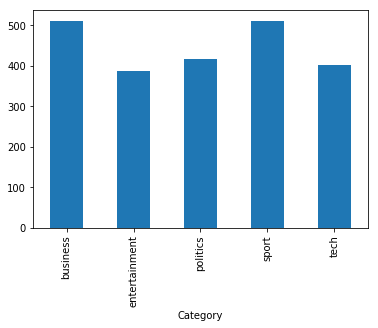

In [281]:
df.groupby('Category').category_id.count().plot.bar(ylim=0)

In [448]:
spacy_tokenizer = lambda rawdoc: lemmatize(tokenize(rawdoc))

In [333]:
tfidf = TfidfVectorizer(tokenizer=spacy_tokenizer, sublinear_tf=True, min_df=5, encoding='latin-1')
features = tfidf.fit_transform(df.Text).toarray()
labels = df.category_id; features.shape

(2225, 7421)

In [334]:
N = 5

for Category, category_id in tqdm(sorted(category_to_id.items())):
    features_chi2 = chi2(features, labels==category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    print('# {}'.format(Category))
    print('  .Most correlated features:\n    .{}'.format('\n    .'.join(feature_names[-N:])))

# business
  .Most correlated features:
    .profit
    .economy
    .oil
    .bank
    .growth
# entertainment
  .Most correlated features:
    .oscar
    .actor
    .star
    .award
    .film
# politics
  .Most correlated features:
    .blair
    .party
    .election
    .tory
    .labour
# sport
  .Most correlated features:
    .injury
    .champion
    .coach
    .match
    .cup
# tech
  .Most correlated features:
    .mobile
    .software
    .technology
    .computer
    .user



In [336]:
tfidf.get_feature_names()

['$1.1bn',
 '$1.2bn',
 '$1.5bn',
 '$1.6bn',
 '$1.8bn',
 '$100m',
 '$1m',
 '$20bn',
 '$24m',
 '$250',
 '$250,000',
 '$27.5bn',
 '$300m',
 '$40m',
 '$50',
 '$50,000',
 '$500m',
 '$50m',
 '$550,000',
 '$5m',
 '$600m',
 '$800m',
 '$9.3bn',
 '$9.4bn',
 '0',
 '0.1%',
 '0.2%',
 '0.3%',
 '0.4%',
 '0.5%',
 '0.6%',
 '0.7%',
 '0.8%',
 '1',
 '1%',
 '1,000',
 '1.1%',
 '1.2%',
 '1.3%',
 '1.5%',
 '1.6%',
 '1.7%',
 '1.8%',
 '10',
 '10%',
 '10,000',
 '10,000m',
 '10-day',
 '10-year',
 '100',
 '100%',
 '100,000',
 '100_million',
 '100m',
 '101',
 '10_days',
 '10_million',
 '10_minutes',
 '10_years',
 '10bn',
 '10th',
 '11',
 '11%',
 '110',
 '11_september',
 '11bn',
 '11th',
 '12',
 '12%',
 '120',
 '1200_gmt',
 '12_months',
 '12_years',
 '12th',
 '13',
 '13%',
 '13th',
 '14',
 '14%',
 '14,000',
 '14-year',
 '15',
 '15%',
 '15-year',
 '150',
 '150,000',
 '1500m',
 '15_january',
 '15_years',
 '15th',
 '16',
 '16%',
 '16-year',
 '17',
 '17%',
 '17-year',
 '17_april',
 '17_december',
 '17_january',
 '17th',


In [337]:
SAMPLE_SIZE = int(len(features)*0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices]); projected_features.shape

(667, 2)

In [338]:
category_id_test = 0
projected_features[labels[indices]==category_id_test]

array([[ 24.886969  ,  14.257374  ],
       [ 42.40711   ,  13.831438  ],
       [ 23.938112  ,  27.832138  ],
       [ 23.471334  ,   8.890546  ],
       [ 10.64879   ,  18.09985   ],
       [ 17.484995  ,  26.658688  ],
       [ 17.253302  ,  12.120572  ],
       [ 39.12284   ,  18.387085  ],
       [ 43.76114   ,  21.834505  ],
       [ 15.754761  ,  29.40553   ],
       [ 35.15391   ,  11.6428175 ],
       [ 20.440405  ,  24.499323  ],
       [ 18.471739  ,  24.039682  ],
       [ 23.042696  ,  14.260636  ],
       [ 26.98738   ,  24.067747  ],
       [ 19.971918  ,   5.4067006 ],
       [ 30.052374  ,  24.17472   ],
       [ 15.820609  ,   8.115982  ],
       [ 31.188318  ,   8.365318  ],
       [ 28.201723  , -10.479337  ],
       [ 27.0397    ,   5.017405  ],
       [ 33.441963  ,  11.641362  ],
       [ 34.71581   ,  11.124921  ],
       [ 34.588352  ,   8.821699  ],
       [ 22.860752  ,   9.912417  ],
       [ 35.357136  ,   8.600018  ],
       [ 30.459108  ,  27.349522  ],
 

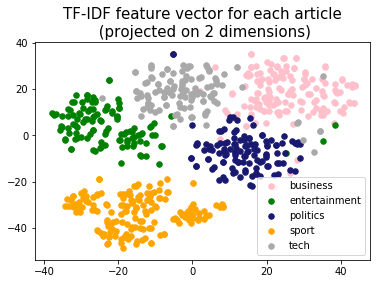

In [339]:
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']

for category, category_id in sorted(category_to_id.items()):
    points = projected_features[labels[indices]==category_id]
    plt.scatter(points[:,0], points[:,1], s=30, c=colors[category_id], label=category)
    
plt.title('TF-IDF feature vector for each article\n (projected on 2 dimensions)', fontdict=dict(fontsize=15))
plt.legend();

In [340]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0), 
    MultinomialNB(), 
    LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto')
]

In [341]:
# CV = 5
shufflesplit = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
entries = []

for model in tqdm(models):
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=shufflesplit)
    
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

In [342]:
cv_df = pd.DataFrame(entries, index=range(5*len(models)), columns=['model_name', 'fold_idx', 'accuracy']); cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.871910
1,RandomForestClassifier,1,0.847191
2,RandomForestClassifier,2,0.844944
3,RandomForestClassifier,3,0.838202
4,RandomForestClassifier,4,0.847191
5,MultinomialNB,0,0.964045
6,MultinomialNB,1,0.966292
7,MultinomialNB,2,0.964045
8,MultinomialNB,3,0.961798
9,MultinomialNB,4,0.977528


In [343]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.978876
MultinomialNB             0.966742
RandomForestClassifier    0.849888
Name: accuracy, dtype: float64

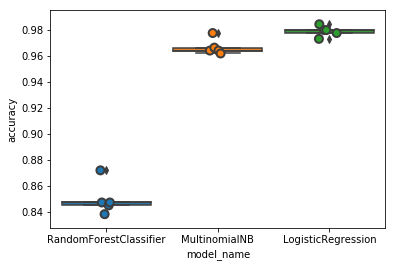

In [344]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor='gray', linewidth=2)

In [345]:
model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto')
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

In [346]:
conf_mat = confusion_matrix(y_test, y_pred); conf_mat

array([[170,   0,   2,   0,   1],
       [  0, 121,   2,   0,   0],
       [  2,   0, 138,   0,   0],
       [  1,   0,   0, 172,   0],
       [  3,   0,   0,   0, 123]], dtype=int64)

Text(0.5, 15.0, 'Predicted')

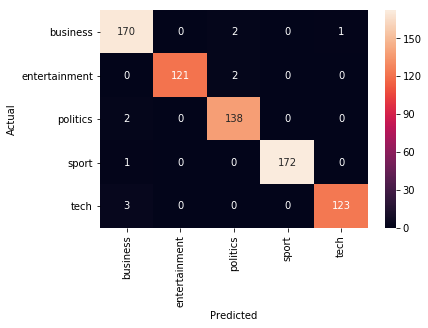

In [347]:
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [348]:
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 2:
            print('{} predicted as {}: {} examples'.format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test==actual) & (y_pred==predicted)]]['Text'])

politics predicted as business: 2 examples


971    Report attacks defence spending\n\nThe Ministr...
979    Job cuts 'false economy'  - TUC\n\nPlans to sh...
Name: Text, dtype: object

tech predicted as business: 3 examples


2065    PC ownership to 'double by 2010'\n\nThe number...
1942    Argonaut founder rebuilds empire\n\nJez San, t...
1937    Games maker fights for survival\n\nOne of Brit...
Name: Text, dtype: object

business predicted as politics: 2 examples


503    Aids and climate top Davos agenda\n\nClimate c...
486    World leaders gather to face uncertainty\n\nMo...
Name: Text, dtype: object

entertainment predicted as politics: 2 examples


722    TV show unites Angolan families\n\nAngolan fam...
711    BBC 'should allow more scrutiny'\n\nMPs have u...
Name: Text, dtype: object

In [349]:
model.fit(features, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [350]:
N = 3

for Category, category_id in tqdm(sorted(category_to_id.items())):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' '))==1]
    bigrams = [v for v in feature_names if len(v.split(' '))==2]
    print('# {}'.format(Category))
    print('  .Most correlated unigrams:\n    .{}'.format('\n    .'.join(unigrams[-N:])))
    print('  .Most correlated bigrams:\n    .{}'.format('\n    .'.join(bigrams[-N:])))

# business
  .Most correlated unigrams:
    .bank
    .company
    .firm
  .Most correlated bigrams:
    .
# entertainment
  .Most correlated unigrams:
    .music
    .star
    .film
  .Most correlated bigrams:
    .
# politics
  .Most correlated unigrams:
    .minister
    .labour
    .party
  .Most correlated bigrams:
    .
# sport
  .Most correlated unigrams:
    .match
    .club
    .win
  .Most correlated bigrams:
    .
# tech
  .Most correlated unigrams:
    .technology
    .user
    .computer
  .Most correlated bigrams:
    .



In [369]:
fnames_test = glob.glob('newsdata/downloaded/*.json')[-10:]

test_data = []
for fname in fnames_test:
    with open(fname, encoding='UTF-8-sig') as f:
        content = json.load(f)
        test_data.append(content['text'])

In [370]:
fnames_test

['newsdata/downloaded\\fff47dea8c8524dafd819ff0f4d7fb3bf2c3eb2e.json',
 'newsdata/downloaded\\fff621185296f1b62d4b04dde73c639c3e9fa0c3.json',
 'newsdata/downloaded\\fff73d2c153889201898f4953e31a0df81ccfd49.json',
 'newsdata/downloaded\\fffb3a399e07b0ca9f168caa2d298d6c7970ebd7.json',
 'newsdata/downloaded\\fffba400853301314ebcbe0a04b4e2200cbc9330.json',
 'newsdata/downloaded\\fffc4188682480a47f2eff3b2b48235cecaf1ce4.json',
 'newsdata/downloaded\\fffcfcad4d05790822d9998aff8e441231c6f295.json',
 'newsdata/downloaded\\fffcfe6039c7646939c5337a4f50b18fb6efbeb7.json',
 'newsdata/downloaded\\fffeea1e862eba451cfad35162fed9232ef7c8ad.json',
 'newsdata/downloaded\\ffff48de38a87141429864e0412283d68d96cc98.json']

In [371]:
test_features = tfidf.transform(test_data)

In [372]:
Y_pred = model.predict(test_features); Y_pred

array([0, 0, 2, 0, 3, 0, 4, 0, 0, 0], dtype=int64)

In [373]:
[id_to_category[cat_id] for cat_id in Y_pred]

['business',
 'business',
 'politics',
 'business',
 'sport',
 'business',
 'tech',
 'business',
 'business',
 'business']

In [377]:
with open('newsdata/downloaded/ffff48de38a87141429864e0412283d68d96cc98.json') as f:
    content = json.load(f)
    print(content['text'])

There is no let-up in the downward spiral of the share values of Uber Technologies (NYSE: ) and LYFT (NASDAQ: ). Both ride-hailing companies have lost almost a quarter of their market capitalization during the past month on concerns that there is no for these companies to achieve profitability.

The shares have plummeted since their IPOs: Closing yesterday at $32.24, Uber is down more than 22% from its maiden trade in May, while Lyft has plunged more than 43% from its March start, to end yesterday's trading at $44.38.

Uber, Lyft price charts

Since they hit the public markets with their IPOs this year, their rides have become ever bumpier as their losses widened and competition grew even stiffer. In the second-quarter reporting season that ended recently, both companies spooked investors with higher-than-expected losses. Uber a net loss of $5.24 billion, while Lyft a $644.2-million loss — more than three times higher than its loss in the year-earlier period.

This dire financial situa

In [449]:
TRAINING_DATA = []
newscat = {'business':False, 'entertainment':False, 'politics':False, 'sport':False, 'tech':False}

for row in tqdm(df.iloc[:][['Text','Category']].itertuples()):
    data = [spacy_tokenizer(row.Text), {**newscat,  row.Category:True}]
    TRAINING_DATA.append(data)

In [451]:
TRAINING_DATA;

In [455]:
import spacy
import random
import json

# TRAINING_DATA = [
#     ["My little kitty is so special", {"animal": True, 'device':False}],
#     ["Dude, Totally, Yeah, Video Games", {"animal": False, 'device':True}],
#     ["Should I pay $1,000 for the iPhone X?", {"animal": False, 'device':True}],
#     ["The iPhone 8 reviews are here", {"animal": False, 'device':True}],
#     ["Noa is a great cat name.", {"animal": True, 'device':False}],
#     ["We got a new kitten!", {"animal": True, 'device':False}]
# ]

# nlp2 = spacy.blank("en")
if not nlp.has_pipe('textcat'):
    category = nlp.create_pipe("textcat")
    # category.add_label("animal")
    # category.add_label("device")

    category.add_label("business")
    category.add_label("entertainment")
    category.add_label("politics")
    category.add_label("sport")
    category.add_label("tech")
    nlp.add_pipe(category)

# Start the training
nlp.begin_training()

# Loop for 10 iterations
for itn in tqdm(range(100)):
    # Shuffle the training data
    random.shuffle(TRAINING_DATA)
    losses = {}

    # Batch the examples and iterate over them
    for batch in spacy.util.minibatch(TRAINING_DATA, size=1):
        #set_trace()
        texts = [text for text, entities in batch]
        #texts = [nlp2(text) for text, entities in batch]
        annotations = [{"cats": entities} for text, entities in batch]
        nlp.update(texts, annotations, losses=losses)
        
    if itn % 20 == 0:
        print(losses)

AttributeError: 'str' object has no attribute 'text'

In [390]:
list(spacy.util.minibatch(TRAINING_DATA, size=1))

[[['The iPhone 8 reviews are here', {'animal': False, 'device': True}]],
 [['Dude, Totally, Yeah, Video Games', {'animal': False, 'device': True}]],
 [['We got a new kitten!', {'animal': True, 'device': False}]],
 [['Should I pay $1,000 for the iPhone X?',
   {'animal': False, 'device': True}]],
 [['My little kitty is so special', {'animal': True, 'device': False}]],
 [['Noa is a great cat name.', {'animal': True, 'device': False}]]]

In [439]:
nlp2('so cute my cat').cats

{'animal': 0.9728940725326538, 'device': 0.252625435590744}

In [442]:
spacy_tokenizer('The iPhone 8 reviews are here')

['iphone', '8', 'reviews']